In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

In [2]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv5v5.csv")

In [3]:
selected_columns = [
    'home_club_id', 'away_club_id', 'attendance', 'home_team_points', 'away_team_points',
    'home_attack_value', 'away_attack_value', 'home_midfield_value', 'away_midfield_value',
    'home_defender_value', 'away_defender_value', 'home_goalkeeper_value', 'away_goalkeeper_value',
    'home_total_market_value', 'away_total_market_value', 'home_power_score', 'away_power_score', 'result'
]
data = data[selected_columns]

data = data.dropna()

print("Class distribution before balancing:")
print(data['result'].value_counts())

Class distribution before balancing:
1    8159
2    5358
0    4554
Name: result, dtype: int64


In [4]:
class_0 = data[data['result'] == 0]  
class_1 = data[data['result'] == 1] 
class_2 = data[data['result'] == 2] 

In [5]:
max_size = max(len(class_0), len(class_1), len(class_2))
class_0_upsampled = resample(class_0, replace=True, n_samples=max_size, random_state=42)
class_1_upsampled = resample(class_1, replace=True, n_samples=max_size, random_state=42)
class_2_upsampled = resample(class_2, replace=True, n_samples=max_size, random_state=42)

In [6]:
data_balanced = pd.concat([class_0_upsampled, class_1_upsampled, class_2_upsampled])
data_balanced = shuffle(data_balanced, random_state=42)

In [7]:
print("Class distribution after balancing:")
print(data_balanced['result'].value_counts())

Class distribution after balancing:
2    8159
1    8159
0    8159
Name: result, dtype: int64


In [8]:
X = data_balanced.drop('result', axis=1)
y = data_balanced['result']

In [9]:
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [10]:
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
def build_model(hp):
    model = Sequential()
    
    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))

    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=64)
    model.add(Dense(units=hp_units_2, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp_dropout))

    model.add(Dense(3, activation='softmax'))

    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [12]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,  
    executions_per_trial=3, 
    directory='my_dir',
    project_name='football_tuning')


Reloading Tuner from my_dir\football_tuning\tuner0.json


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

In [14]:
tuner.search(X_train, y_train, epochs=150, validation_data=(X_test, y_test), 
             callbacks=[early_stopping, lr_scheduler])

best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), 
                         callbacks=[early_stopping, lr_scheduler])

Trial 30 Complete [00h 12m 24s]
val_accuracy: 0.5078975955645243

Best val_accuracy So Far: 0.7215686241785685
Total elapsed time: 2d 09h 09m 05s
Epoch 1/150
574/574 [==============================] - 5s 8ms/step - loss: 0.6204 - accuracy: 0.7671 - val_loss: 0.8023 - val_accuracy: 0.7190 - lr: 3.3610e-05
Epoch 2/150
574/574 [==============================] - 3s 4ms/step - loss: 0.6253 - accuracy: 0.7631 - val_loss: 0.8054 - val_accuracy: 0.7204 - lr: 3.3610e-05
Epoch 3/150
574/574 [==============================] - 3s 6ms/step - loss: 0.6123 - accuracy: 0.7717 - val_loss: 0.8050 - val_accuracy: 0.7170 - lr: 3.3610e-05
Epoch 4/150
574/574 [==============================] - 3s 4ms/step - loss: 0.6185 - accuracy: 0.7693 - val_loss: 0.8085 - val_accuracy: 0.7183 - lr: 3.3610e-05
Epoch 5/150
574/574 [==============================] - 4s 7ms/step - loss: 0.6192 - accuracy: 0.7682 - val_loss: 0.8048 - val_accuracy: 0.7257 - lr: 3.3610e-05
Epoch 6/150
574/574 [==============================] -

574/574 [==============================] - 3s 6ms/step - loss: 0.5604 - accuracy: 0.7981 - val_loss: 0.7821 - val_accuracy: 0.7441 - lr: 4.2012e-06
Epoch 52/150
574/574 [==============================] - 3s 5ms/step - loss: 0.5617 - accuracy: 0.7947 - val_loss: 0.7827 - val_accuracy: 0.7430 - lr: 4.2012e-06
Epoch 53/150
574/574 [==============================] - 3s 6ms/step - loss: 0.5659 - accuracy: 0.7899 - val_loss: 0.7849 - val_accuracy: 0.7423 - lr: 4.2012e-06
Epoch 54/150
574/574 [==============================] - 3s 5ms/step - loss: 0.5620 - accuracy: 0.7917 - val_loss: 0.7825 - val_accuracy: 0.7422 - lr: 4.2012e-06
Epoch 55/150
574/574 [==============================] - 3s 5ms/step - loss: 0.5652 - accuracy: 0.7905 - val_loss: 0.7814 - val_accuracy: 0.7433 - lr: 4.2012e-06
Epoch 56/150
574/574 [==============================] - 3s 5ms/step - loss: 0.5635 - accuracy: 0.7944 - val_loss: 0.7822 - val_accuracy: 0.7431 - lr: 4.2012e-06
Epoch 57/150
574/574 [=========================

In [15]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

192/192 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      2074
           1       0.75      0.73      0.74      2055
           2       0.75      0.78      0.76      1991

    accuracy                           0.74      6120
   macro avg       0.74      0.74      0.74      6120
weighted avg       0.74      0.74      0.74      6120



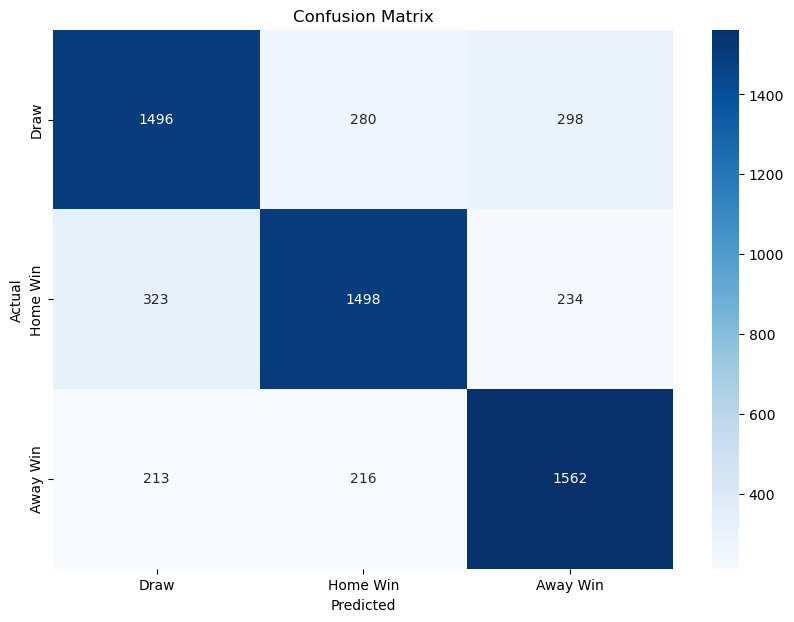

In [16]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Draw', 'Home Win', 'Away Win'],
            yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict_match(model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                  home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                  home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                  home_total_market_value, away_total_market_value, home_power_score, away_power_score):

    match_features = np.array([home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                               home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                               home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                               home_total_market_value, away_total_market_value, home_power_score, away_power_score]).reshape(1, -1)
    
    match_features = scaler.transform(match_features)
    
    prediction = model.predict(match_features)
    
    return prediction

In [20]:
home_team_id = 162
away_team_id = 583
attendance = -0.799500
home_team_points = 0.623097
away_team_points = 1.064934
home_attack_value = 0.186794
away_attack_value = 5.482963
home_midfield_value = -0.697554
away_midfield_value = 0.571892
home_defender_value = 0.511353
away_defender_value = 0.906488
home_goalkeeper_value = -0.172559
away_goalkeeper_value = 0.164418
home_total_market_value = 0.198449
away_total_market_value = 3.077390
home_power_score = 0.152487
away_power_score = 2.597862

prediction = predict_match(best_model, home_team_id, away_team_id, attendance, home_team_points, away_team_points,
                           home_attack_value, away_attack_value, home_midfield_value, away_midfield_value,
                           home_defender_value, away_defender_value, home_goalkeeper_value, away_goalkeeper_value,
                           home_total_market_value, away_total_market_value, home_power_score, away_power_score)

print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 20ms/step
Prediction: [[1.2857946e-04 3.0732795e-04 9.9956411e-01]]


C:\Users\Akif\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [19]:
print(conf_matrix)

[[1496  280  298]
 [ 323 1498  234]
 [ 213  216 1562]]


Trial 15 Complete [00h 16m 57s]
val_accuracy: 0.49569716056187946

Best val_accuracy So Far: 0.7215686241785685
Total elapsed time: 2d 02h 11m 05s

Search: Running Trial #16

Value             |Best Value So Far |Hyperparameter
512               |512               |units
0.2               |0.2               |dropout_rate
192               |256               |units_2
0.0018076         |0.00013444        |learning_rate